In [47]:
import pandas as pd
import matplotlib.pyplot as plt 
import time
import datetime
import numpy as np


In [48]:
def to_ts(date):
    if   "-" in date:
        forme = "%Y-%m-%d"
    elif "/" in date:
        forme = "%m/%d/%Y"
        
    return time.mktime(datetime.datetime.strptime(date, forme).timetuple())

In [49]:
df = pd.read_excel('DF(t) .xlsx')
df2 = pd.read_excel('Bloom_EUR_OIS.xlsx')
df.columns=['t','DF(t)']

In [50]:
df.tail()

,t,DF(t)
18257,2070-12-27,1.069258
18258,2070-12-28,1.069266
18259,2070-12-29,1.069274
18260,2070-12-30,1.069282
18261,2070-12-31,1.069290


In [51]:
df2.head()

,Payment Date,Maturity Date,Market Rate,Shift (bp),Shifted Rate,Zero Rate,Discount,Source
0,01/06/2021,01/06/2021,-0.4980,0,-0.4980,-0.504920,1.000014,CASH
1,01/12/2021,01/12/2021,-0.4700,0,-0.4700,-0.476550,1.000091,DETAILED_SWAP
2,01/19/2021,01/19/2021,-0.4700,0,-0.4700,-0.476572,1.000183,DETAILED_SWAP
3,02/05/2021,02/05/2021,-0.4719,0,-0.4719,-0.478551,1.000407,DETAILED_SWAP
4,03/05/2021,03/05/2021,-0.4750,0,-0.4750,-0.481785,1.000779,DETAILED_SWAP


In [52]:
def append_m_rate(date):
    k=0
    try:
        while not to_ts(df2.T[k]['Payment Date'])<= to_ts(date) <= to_ts(df2.T[k+1]['Payment Date']):
            k+=1

        return df2.T[k]['Market Rate']
    except:
        return 0.0

def keep_date(date_w_hours):
    return str(date_w_hours).split(" ")[0]

#df['t'] = df['t'].apply(keep_date)

In [53]:
#df['Market Rate'] = df['t'].apply(append_m_rate)
df['t']

0       2021-01-01
1       2021-01-02
2       2021-01-03
3       2021-01-04
4       2021-01-05
           ...    
18257   2070-12-27
18258   2070-12-28
18259   2070-12-29
18260   2070-12-30
18261   2070-12-31
Name: t, Length: 18262, dtype: datetime64[ns]

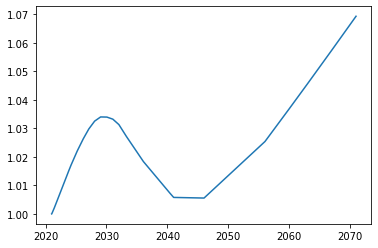

In [8]:
plt.plot(df['t'],df['DF(t)'])
plt.show()

In [12]:
df['t'][0]

df['t'][1]

(df['t'][1]<df['t'][0])

df.head()

,t,DF(t)
0,2021-01-01,1.0
1,2021-01-02,1.0
2,2021-01-03,1.0
3,2021-01-04,1.0
4,2021-01-05,1.0


In [153]:
# P = DF
class Stripper:
    def __init__(self):
        #self.df = pd.read_excel('DF(t) .xlsx')
        self.df = pd.read_csv('data.csv')
        self.df2 = pd.read_excel('Bloom_EUR_OIS.xlsx')
        self.df2['Payment Date'] = self.df2['Payment Date'].apply(self.temps)
        #self.df.columns=['t','DF(t)']
        
        self.df['t'] = pd.to_datetime(self.df['t'])
        self.n = len(self.df)
        self.N = 100
        self.R = .4
        self.LGD = 1-self.R
    
    def temps(self,x):
        return datetime.datetime.strptime(x,  "%m/%d/%Y")
    
    
    def delta(self,t1,t2):
        return (t2-t1).days

    def P(self, t,T):
        return np.average(self.df[self.df.t <= T]['DF(t)'])
    
    def F(self,t,S,T):
        return (self.P(t,S)/self.P(t,T)-1)/self.delta(S,T)
        
        
        
    def m_rate(self,date):
        k=0
        max_k = len(self.df2.T)
        while not self.df2.T[k]['Payment Date']<= date :#<= self.df2.T[k+1]['Payment Date']:
            k+=1
            if k == max_k-2:
                print("error")
                break

        return self.df2.T[k]['Market Rate']

        
    def append_m_rate(self):
        self.df['MarketRate'] = np.vectorize(self.m_rate)(self.df['t'])
    
        
    def append_prices(self):
        self.df['V'] = np.cumsum(self.df['MarketRate']*self.df['DF(t)'])

        
        
    def polynome(self,t, p = .5):
        
        #t = self.df['t'][i]
        s = 0
        
        for j in range(1+list(stripper.df['t']).index(t),self.n):
            T    = self.df['t'][j]
            T_1  = self.df['t'][j-1]
            
            s +=    self.P(t,T)*         \
                    p**self.delta(t,T)*  \
                    self.F(t,T_1,T)*     \
                    self.delta(T_1,T)    \
                    +                    \
                    (p**self.delta(t,T_1) - p**self.delta(t,T))*(1-self.LGD)


        s += self.P(t, list(self.df['t'])[-1])* p**self.delta(t, list(self.df['t'])[-1])

        return s

        
        
        
         

In [154]:
stripper = Stripper()

In [155]:
#stripper.append_m_rate()

In [156]:
stripper.df2.tail()

,Payment Date,Maturity Date,Market Rate,Shift (bp),Shifted Rate,Zero Rate,Discount,Source
30,2046-01-05,01/05/2046,-0.01950,0,-0.01950,-0.021394,1.005366,DETAILED_SWAP
31,2051-01-05,01/05/2051,-0.04800,0,-0.04800,-0.049896,1.015091,DETAILED_SWAP
32,2056-01-05,01/05/2056,-0.06835,0,-0.06835,-0.070019,1.024825,DETAILED_SWAP
33,2061-01-05,01/05/2061,-0.09475,0,-0.09475,-0.095950,1.039153,DETAILED_SWAP
34,2071-01-05,01/05/2071,-0.13300,0,-0.13300,-0.133135,1.068880,DETAILED_SWAP


In [157]:
#stripper.df.to_csv('data.csv')

In [158]:
stripper.df.head()

,Unnamed: 0,t,DF(t),MarketRate
0,0,2021-01-01,1.0,-0.48225
1,1,2021-01-02,1.0,-0.48225
2,2,2021-01-03,1.0,-0.48225
3,3,2021-01-04,1.0,-0.48225
4,4,2021-01-05,1.0,-0.48225


In [159]:
"""
Idée pour la résolution numérique
"""

def polynome(p):
    return (p-.45678)
    
def solve_polynome(polynome, epsilon = 1e-5):
    a = 0
    b = 1
    p = (b+a) / 2
    
    while np.abs(polynome(p))>epsilon:
        if polynome(p) < 0:
            a=p
        else:
            b=p
        p=(b+a)/2
        
    return p 
    

In [162]:
print("évaluation du polynome pour différentes valeurs de t \navec p fixé p = 0.5 \n\n")

for t in stripper.df['t']:
    print("==================")
    print(stripper.polynome(t))
    #stripper.polynome(t)

évaluation du polynome pour différentes valeurs de t 
avec p fixé p = 0.5 




KeyboardInterrupt: 